In [391]:
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.transforms as tf
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import cm, colormaps, colors

from functools import cache
import cartopy.crs as ccrs

In [71]:
wrf_N_days = 4992
inmcm_N_days = 3650

In [92]:
month_name = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]

In [270]:
cmap = colormaps.get_cmap('tab20')

In [400]:
def std_error(avg_val, avg_sqr, counter):
    """
    Estimate the standard error from the average value
    and the average value of the square.
    
    :param avg_val: the average value
    :param avg_sqr: the average square value
    :param counter: the size of the sample
    
    :return: the standard error
    """

    return np.sqrt((avg_sqr - avg_val**2) / (counter - 1))

In [413]:
wrf_dt_indicies = np.array(
    [dt.date(1980, 1, 1) + dt.timedelta(i * 3) for i in range(wrf_N_days)]
)

inmcm_dt_indicies = np.array(
    [dt.date(2022, 1, 1) + dt.timedelta(i % 365) for i in range(inmcm_N_days)]
)

def wrf_month_indices(month_idx):
    return np.array([i for i, date in enumerate(wrf_dt_indicies) if date.month == month_idx + 1])

def inmcm_month_indices(month_idx):
    return np.array([i for i, date in enumerate(inmcm_dt_indicies) if date.month == month_idx + 1])

@cache
def get_wrf_total_ip(cape_thres, month_idx):
    data = np.load(f'./data/WRF/WRF_HOURLY_TOTAL_IP_{cape_thres}.npy')
    return data[wrf_month_indices(month_idx)]

@cache
def get_inm_total_ip(cape_thres, month_idx):
    data = np.load(f'./data/INMCM/INMCM_HOURLY_TOTAL_IP_{cape_thres}.npy')
    return data[inmcm_month_indices(month_idx)]

@cache
def get_wrf_ip_strip(cape_thres, s):
    data = np.load(f'./data/WRF/WRF_IP_{cape_thres}_LATxMON.npy')
    return data[s, :]

@cache
def get_inm_ip_strip(cape_thres, s):
    data = np.load(f'./data/INMCM/INMCM_IP_{cape_thres}_LATxMON.npy')
    return data[s, :]

@cache
def get_wrf_t2_strip(s):
    data = np.load(f'./data/WRF/WRF_T2_LATxMON.npy')
    return data[s, :]

@cache
def get_wrf_t2_strip_mean(s):
    # area factors for different latitudes
    area_factor = (
        np.cos(np.arange(180) * np.pi / 180) - np.cos(np.arange(1, 181) * np.pi / 180)
    ) / 2
    
    data = np.load(f'./data/WRF/WRF_T2_LATxMON.npy')

    print(area_factor.shape, s)
    return np.sum(
        data[s, :]
        * area_factor[s, np.newaxis],
        axis=0,
    ) / np.sum(area_factor[s, np.newaxis])

In [402]:
class LatitudeStrip():
    def __init__(self, tokens, model=None):
        s1, s2 = tokens.split("-")
        s1 = s1 if s1 != "0" else "0S"
        s2 = s2 if s2 != "0" else "0S"
    
        for s in [s1, s2]:
            assert s[-1] in "NS"
            assert s[:-1].isdigit()
        
        N1 = int(s1[:-1])*(-1 if s1[-1] == "S" else 1)
        N2 = int(s2[:-1])*(-1 if s2[-1] == "S" else 1)

        if N1 == 0:
            p1 = "0°"
        else:
            p1 = f"{abs(N1):d}° {'S' if N1 < 0 else 'N'}"
        if N2 == 0:
            p2 = "0°"
        else:
            p2 = f"{abs(N2):d}° {'S' if N2 < 0 else 'N'}"
        
        Z = (N1 + N2) / 2
        
        assert model in ["WRF", "INMCM"]
        degrees = 1 if model == "WRF" else 1.5
        central_idx = 90 if model == "WRF" else 60
    
        for N in [N1, N2]:
            assert N%degrees == 0
    
        N1 = N1//degrees + central_idx
        N2 = N2//degrees + central_idx
        N1, N2 = sorted([N1, N2])

        self.slice = slice(int(N1), int(N2), 1)

        self.indicies = tuple(np.arange(*self.slice.indices(10000)).tolist())

        self.model = model
        
        if 0 < Z < 9:
            self.color = cmap(7 / 40)
        elif -9 < Z < 0:
            self.color = cmap(5 / 40)
        elif -18 < Z < -9:
            self.color = cmap(39 / 40)
        elif -90 < Z < -18:
            self.color = cmap(37 / 40)
        elif 9 < Z < 18:
            self.color = cmap(35 / 40)
        elif 18 < Z < 90:
            self.color = cmap(33 / 40)

        self.title = f"{p1}–{p2}" # like 9° S–18° S

In [403]:
data = np.zeros((7, 12))
data_counter = np.zeros((7, 12), dtype=int)
data_sqr = np.zeros((7, 12))

for j, cape_thres in enumerate([800, 1000, 1200]):
    for m in range(12):
        # fill data for WRF panels
        ax_idx = j * 2

        data[ax_idx, m] = get_wrf_total_ip(cape_thres, m).mean()
        data_counter[ax_idx, m] = len(get_wrf_total_ip(cape_thres, m))
        data_sqr[ax_idx, m] = np.sum(
            get_wrf_total_ip(cape_thres, m).mean(axis=-1) ** 2
        ) / len(get_wrf_total_ip(cape_thres, m))

        # fill data for INMCM panels
        ax_idx = j * 2 + 1

        data[ax_idx, m] = get_inm_total_ip(cape_thres, m).mean()
        data_counter[ax_idx, m] = len(get_inm_total_ip(cape_thres, m))
        data_sqr[ax_idx, m] = np.sum(
            get_inm_total_ip(cape_thres, m).mean(axis=-1) ** 2
        ) / len(get_inm_total_ip(cape_thres, m))

# latest point is Vostok results from previous script
# keys: mean, counter, sqr
# index 0: 2006-2020, index 1: 2006-2012, index 2: 2013-2020
vostok_results = np.load("./data/vostok_2006_2020_results.npz")

data[-1] = vostok_results["mean"][0]
data_counter[-1] = vostok_results["counter"][0]
data_sqr[-1] = vostok_results["sqr"][0]

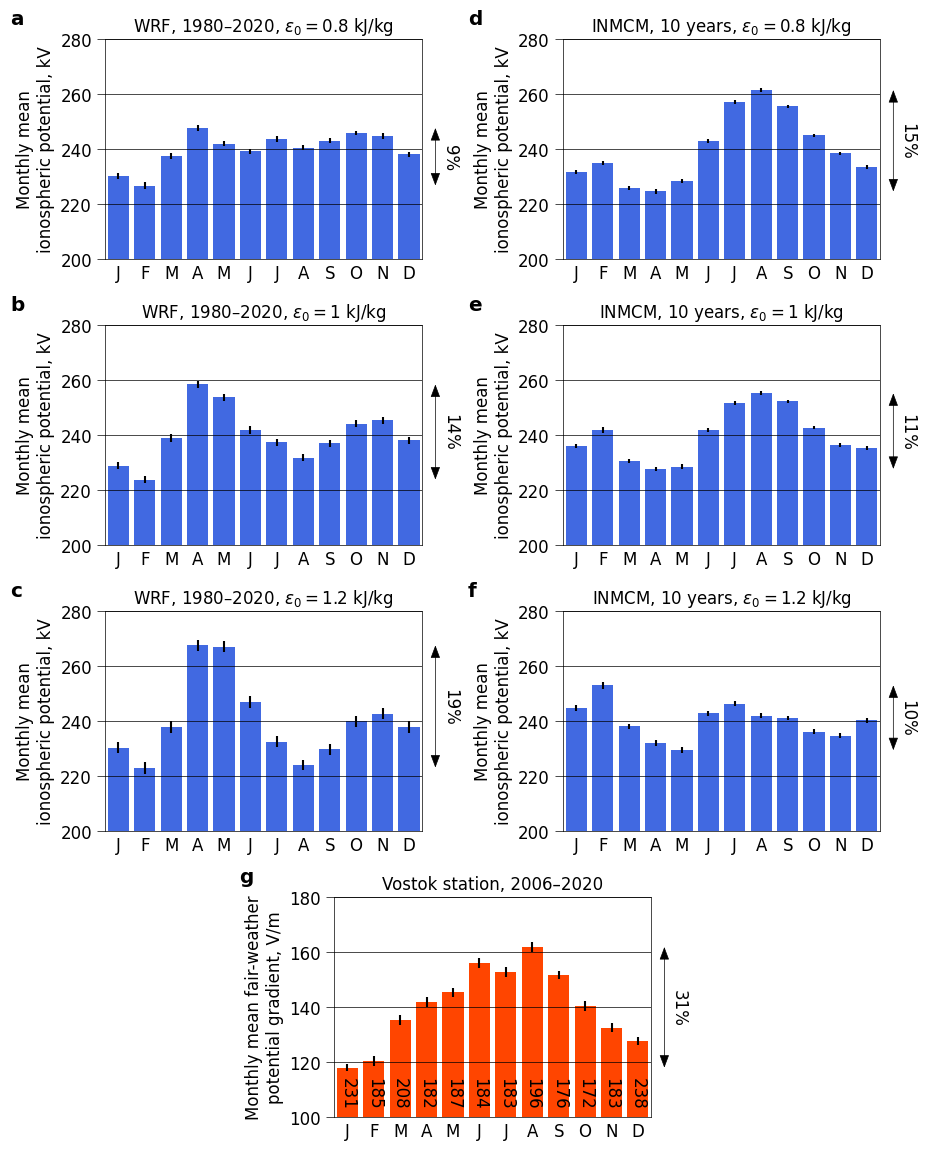

In [404]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = [None for _ in range(7)]
for n in range(6):
    ax[n] = fig.add_subplot(4, 4, (2*n + 1, 2*n + 2))
ax[6] = fig.add_subplot(4, 4, (14, 15))

low = [200e3] * 6 + [100]
high = [280e3] * 6 + [180]
step = [20e3] * 6 + [20]
coeff = [1e3] * 6 + [1]
caption = ['WRF, 1980–2020, $\\varepsilon_0 = 0.8$ kJ/kg',
           'INMCM, 10 years, $\\varepsilon_0 = 0.8$ kJ/kg',
           'WRF, 1980–2020, $\\varepsilon_0 = 1$ kJ/kg',
           'INMCM, 10 years, $\\varepsilon_0 = 1$ kJ/kg',
           'WRF, 1980–2020, $\\varepsilon_0 = 1.2$ kJ/kg',
           'INMCM, 10 years, $\\varepsilon_0 = 1.2$ kJ/kg',
           'Vostok station, 2006–2020']

col = ['royalblue'] * 6 + ['orangered']

for n in range(7):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis='y')
    ax[n].tick_params(length=0, width=0.5, axis='x')
    ax[n].grid(color='0.', linewidth=0.5, axis='y')

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize='large', va='top')

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize='large')
    if n < 6:
        ax[n].set_ylabel('Monthly mean\nionospheric potential, kV',
                         fontsize='large')
    else:
        ax[n].set_ylabel('Monthly mean fair-weather\npotential gradient, V/m',
                         fontsize='large')

    ax[n].set_title(caption[n], fontsize='large')

    ax[n].annotate('', xy=(12, np.min(data[n])), xycoords='data',
                   xytext=(12, np.max(data[n])), textcoords='data',
                   annotation_clip=False,
                   arrowprops=dict(
                       arrowstyle='<|-|>,head_length=0.8,head_width=0.3',
                       patchA=None, patchB=None, shrinkA=0., shrinkB=0.,
                       connectionstyle='arc3,rad=0.', fc='black',
                       linewidth=0.5
                   ))
    # ampl = (np.max(data[n]) - np.min(data[n])) / np.mean(data[n])
    ampl = (np.max(data[n]) - np.min(data[n])) / \
        np.sum(data[n] * data_counter[n]) * np.sum(data_counter[n])
    ax[n].text(12.2, (np.min(data[n]) + np.max(data[n])) / 2,
               f'{ampl * 100:.0f}%',
               fontsize='large', ha='left', va='center', rotation=270)

fig.align_ylabels([ax[0], ax[2], ax[4]])
fig.align_ylabels([ax[1], ax[3], ax[5]])

for n in range(7):
    ax[n].bar(np.arange(12), data[n],
              yerr=std_error(data[n],
                             data_sqr[n],
                             data_counter[n]),
              width=0.8, color=col[n])

for n in range(6):
    ax[n].text(-0.3, 1.05, chr(ord('a') + 3 * (n % 2) + n // 2),
               fontsize='x-large',
               fontweight='semibold', ha='left', va='bottom',
               transform=ax[n].transAxes)
ax[6].text(-0.3, 1.05, chr(ord('a') + 6), fontsize='x-large',
           fontweight='semibold', ha='left', va='bottom',
           transform=ax[6].transAxes)

fig.subplots_adjust(hspace=0.3, wspace=1.6)

for m in range(12):
    ax[6].annotate(f'{data_counter[6, m]}',
                   xy=(m, ax[6].get_ylim()[0] + 3),
                   rotation=270, ha='center', va='bottom',
                   fontsize='large', color='0.')

fig.savefig('./figures_two_parts/ip_pg_total.eps', bbox_inches='tight')

In [407]:
text_strips = ["0-9N", "0-9S", "9S-18S", "18S-90S", "9N-18N", "18N-90N"]
wrf_strips = [LatitudeStrip(t, model="WRF") for t in text_strips]
inmcm_strips = [LatitudeStrip(t, model="INMCM") for t in text_strips]

bar_data = np.zeros((6, len(wrf_strips), 12))
# (axes, strips, months)

for j, cape_thres in enumerate([800, 1000, 1200]):
    ax_idx = j * 2
    for i, strip in enumerate(wrf_strips):
        bar_data[ax_idx, i] = get_wrf_ip_strip(cape_thres, strip.indicies).sum(axis=0)

    ax_idx = j * 2 + 1
    for i, strip in enumerate(inmcm_strips):
        bar_data[ax_idx, i] = get_inm_ip_strip(cape_thres, strip.indicies).sum(axis=0)

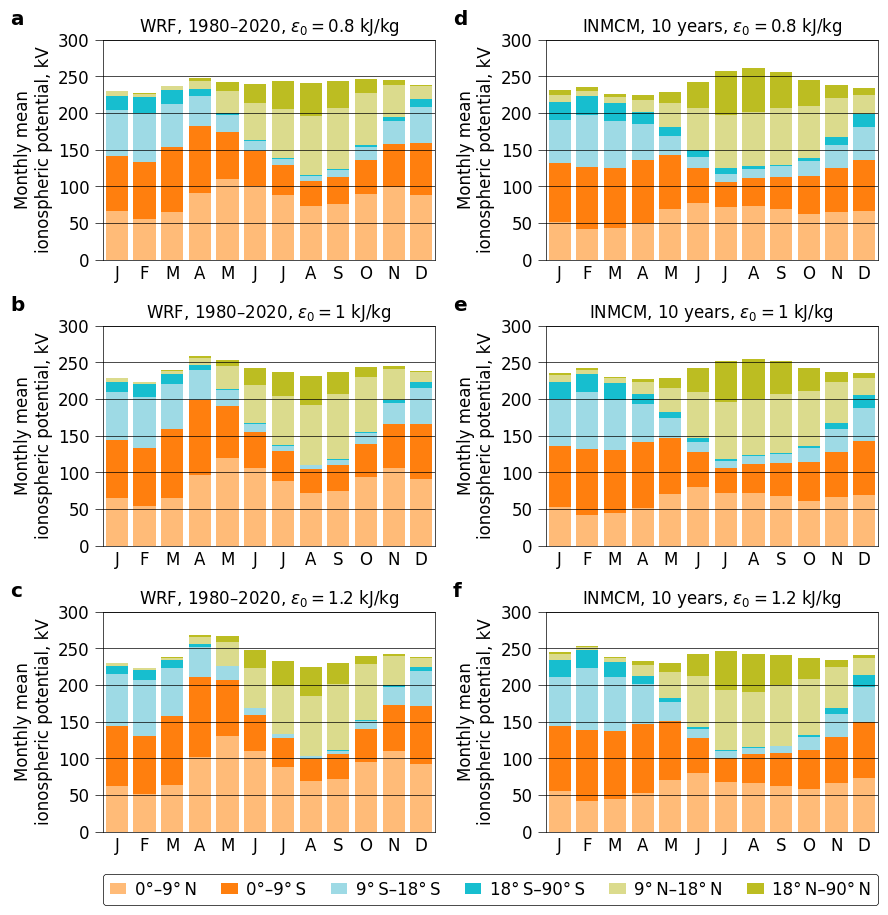

In [408]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = [None for _ in range(6)]
for n in range(6):
    ax[n] = fig.add_subplot(4, 4, (2*n + 1, 2*n + 2))

low = [0e3] * 6
high = [300e3] * 6
step = [50e3] * 6
coeff = [1e3] * 6
caption = ['WRF, 1980–2020, $\\varepsilon_0 = 0.8$ kJ/kg',
           'INMCM, 10 years, $\\varepsilon_0 = 0.8$ kJ/kg',
           'WRF, 1980–2020, $\\varepsilon_0 = 1$ kJ/kg',
           'INMCM, 10 years, $\\varepsilon_0 = 1$ kJ/kg',
           'WRF, 1980–2020, $\\varepsilon_0 = 1.2$ kJ/kg',
           'INMCM, 10 years, $\\varepsilon_0 = 1.2$ kJ/kg']
lab = ['18° S–90° S',
       '9° S–18° S',
       '0°–9° S',
       '0°–9° N',
       '9° N–18° N',
       '18° N–90° N']
# thin spaces (' ') are used between ‘°’ signs and letters

for n in range(6):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis='y')
    ax[n].tick_params(length=0, width=0.5, axis='x')
    ax[n].grid(color='0.', linewidth=0.5, axis='y')

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize='large', va='top')

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize='large')
    ax[n].set_ylabel('Monthly mean\nionospheric potential, kV',
                     fontsize='large')

    ax[n].set_title(caption[n], fontsize='large')

fig.align_ylabels([ax[0], ax[2], ax[4]])
fig.align_ylabels([ax[1], ax[3], ax[5]])


for n in range(6):
    bottom_data = np.zeros(12)
    for k in range(len(text_strips)):
        data = bar_data[n, k]
        ax[n].bar(
            np.arange(12),
            data,
            0.8,
            color=wrf_strips[k].color,
            bottom=bottom_data,
            label=wrf_strips[k].title,
        )
        bottom_data += data
        

for n in range(6):
    ax[n].text(-0.28, 1.05, chr(ord('a') + 3 * (n % 2) + n // 2),
               fontsize='x-large',
               fontweight='semibold', ha='left', va='bottom',
               transform=ax[n].transAxes)

fig.subplots_adjust(hspace=0.3, wspace=1.)

leg_width_rel = (ax[5].get_position().x1 - ax[4].get_position().x0) \
    / (ax[4].get_position().x1 - ax[4].get_position().x0)

leg = ax[4].legend(bbox_to_anchor=(0., -1./3, leg_width_rel, 1./6), ncols=6,
                   loc='lower center', borderaxespad=0.,
                   mode='expand', fontsize='large',
                   framealpha=1, edgecolor='0.',
                   handlelength=1., handletextpad=0.5)
leg.get_frame().set_linewidth(0.5)

fig.savefig('figures_two_parts/ip_decomposed.eps', bbox_inches='tight')

In [418]:
text_strips = ["18N-90N", "9N-18N", "0-9N", "0-9S", "9S-18S", "18S-90S"]
wrf_strips = [LatitudeStrip(t, model="WRF") for t in text_strips]
inmcm_strips = [LatitudeStrip(t, model="INMCM") for t in text_strips]
wrf_t2_strips = [LatitudeStrip(t, model="WRF") for t in ["18N-30N"]+text_strips[1:-1]+["18S-30S"]]

In [441]:
WRF_IP_LxM = get_wrf_ip_strip(1000, LatitudeStrip("30S-30N", model="WRF").indicies) / 360
INMCM_LxM = get_inm_ip_strip(1000, LatitudeStrip("30S-30N", model="INMCM").indicies) / 180
T2_LxM = get_wrf_t2_strip(LatitudeStrip("30S-30N", model="WRF").indicies)

In [445]:
strip_map = np.full((180, 360, 4), 1.)

for strip in wrf_t2_strips:
    for i in strip.indicies:
        for j in range(360):
            strip_map[i, j] = strip.color

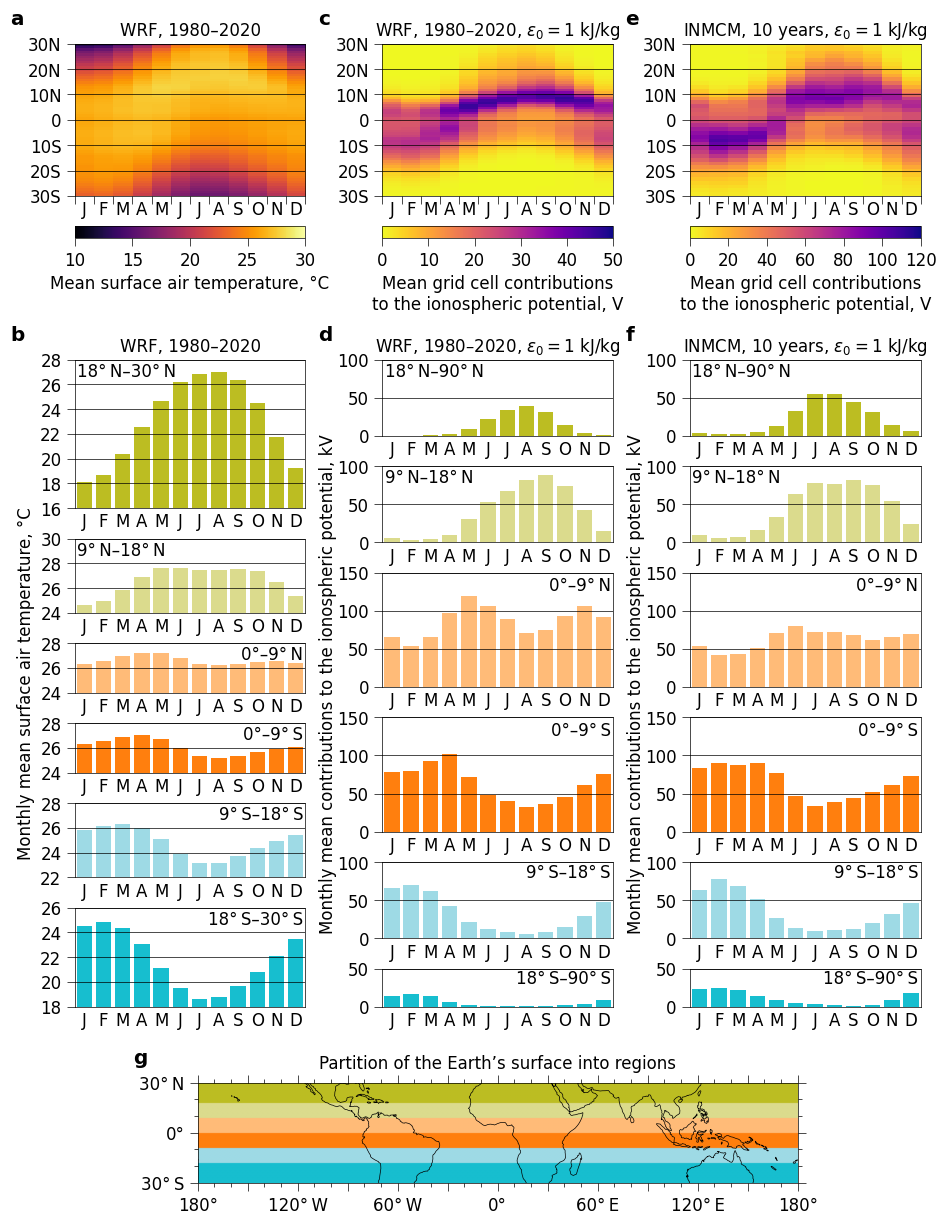

In [446]:
# assert len(bound_lat) == 5
# assert bound_lat[2] == 0

fig_width = 10
fig_height = 12

width = 3.
wsp = 1.
tot_width = 3 * width + 4 * wsp
widthM = 0.6 * tot_width

height = np.array([2., 2., 3., 3., 2., 1.])
hsp = 0.8
hsep1 = 2.
hsep2 = 3.5
assert len(height) == 6
heightD = 4.
heightM = widthM/tot_width * 60/360 * fig_width/fig_height
tot_height = (sum(height) + heightD + 8 * hsp + hsep1 + hsep2) / (1 - heightM)
heightM *= tot_height

sizeT = np.array([6., 3., 2., 2., 3., 4.])
hspT = hsp
assert len(sizeT) == 6
heightT = sizeT * (sum(height) + 5 * hsp - 5 * hspT) / sum(sizeT)
minT = np.array([16., 24., 24., 24., 22., 18.])

fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=False)

ax = [None for _ in range(12)]
axT = [None for _ in range(6)]

for n in range(6):
    ax[2*n] = fig.add_axes(
        (
            (width + 2 * wsp) / tot_width,
            (sum(height[n+1:]) + heightM + (6 - n) * hsp + hsep1) / tot_height,
            width / tot_width,
            height[n] / tot_height
        )
    )
    ax[2*n + 1] = fig.add_axes(
        (
            (2 * width + 3 * wsp) / tot_width,
            (sum(height[n+1:]) + heightM + (6 - n) * hsp + hsep1) / tot_height,
            width / tot_width,
            height[n] / tot_height
        )
    )
    axT[n] = fig.add_axes(
        (
            wsp / tot_width,
            (sum(heightT[n+1:]) + (5 - n) * hspT
             + heightM + hsp + hsep1) / tot_height,
            width / tot_width,
            heightT[n] / tot_height
        )
    )

axD = [None for _ in range(3)]

for n in range(3):
    axD[n] = fig.add_axes(
        (
            (n * width + (n + 1) * wsp) / tot_width,
            (sum(height) + heightM + 7 * hsp + hsep1 + hsep2) / tot_height,
            width / tot_width,
            heightD / tot_height
        )
    )

axM = fig.add_axes(
    (
        (1 - widthM / tot_width) / 2,
        hsp / tot_height,
        widthM / tot_width,
        heightM / tot_height
    ),
    projection=ccrs.PlateCarree(central_longitude=0)
)
axM.coastlines('110m', linewidth=0.5)

caption = ['WRF, 1980–2020, $\\varepsilon_0 = 1$ kJ/kg',
           'INMCM, 10 years, $\\varepsilon_0 = 1$ kJ/kg']

captionT = 'WRF, 1980–2020'

captionD = ['WRF, 1980–2020',
            'WRF, 1980–2020, $\\varepsilon_0 = 1$ kJ/kg',
            'INMCM, 10 years, $\\varepsilon_0 = 1$ kJ/kg']

for n in range(12):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis='y')
    ax[n].tick_params(length=0, width=0.5, axis='x')
    ax[n].grid(color='0.', linewidth=0.5, axis='y')

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize='large', va='top')

    low = 0
    high = 50e3 * height[n // 2]
    step = 50e3
    coeff = 1e3
    ax[n].set_ylim((low, high))
    ax[n].set_yticks(np.arange(low, high + step / 2, step))
    ax[n].set_yticklabels((np.arange(low, high + step / 1,
                                     step) / coeff).astype(int),
                          fontsize='large')

    if n < 2:
        ax[n].set_title(caption[n], fontsize='large')


for n in range(2):
    lbl = ax[n].set_ylabel('Monthly mean contributions '
                           'to the ionospheric potential, kV',
                           fontsize='large', labelpad=0.)
    lbl.set_position((0., 1 - (sum(height) + 5 * hsp) / 2 / height[0]))

for n in range(6):
    for axis in ['top', 'bottom', 'left', 'right']:
        axT[n].spines[axis].set_linewidth(0.5)
    axT[n].tick_params(length=6, width=0.5, axis='y')
    axT[n].tick_params(length=0, width=0.5, axis='x')
    axT[n].grid(color='0.', linewidth=0.5, axis='y')

    axT[n].set_xlim((-0.5, 11.5))
    axT[n].set_xticks(np.arange(12))
    axT[n].set_xticklabels(month_name, fontsize='large', va='top')

    low = minT[n]
    step = 2
    high = minT[n] + step * sizeT[n]
    coeff = 1
    axT[n].set_ylim((low, high))
    axT[n].set_yticks(np.arange(low, high + step / 2, step))
    axT[n].set_yticklabels((np.arange(low, high + step / 2,
                                      step) / coeff).astype(int),
                           fontsize='large')

    if n == 0:
        axT[n].set_title(captionT, fontsize='large')


lbl = axT[0].set_ylabel('Monthly mean surface air temperature, °C',
                        fontsize='large')
lbl.set_position((0., 1 - (sum(heightT) + 5 * hspT) / 2 / heightT[0]))

for n in range(3):
    for axis in ['top', 'bottom', 'left', 'right']:
        axD[n].spines[axis].set_linewidth(0.5)
    axD[n].tick_params(length=6, width=0.5)
    axD[n].tick_params(length=0, width=0.5, which='minor')
    axD[n].grid(color='0.', linewidth=0.5, axis='y')

    axD[n].set_xlim((0, 12))
    axD[n].set_xticks(np.arange(0, 12.5, 1))
    axD[n].set_xticks(np.arange(0.5, 12, 1), minor=True)
    axD[n].set_xticklabels([])
    axD[n].set_xticklabels(month_name, fontsize='large', va='top',
                           minor=True)

    axD[n].set_ylim((-30, 30))
    axD[n].set_yticks(np.arange(-30, 31, 10))
    axD[n].set_yticklabels(['0' if v == 0 else f'{-v}S' if v < 0 else f'{v}N'
                            for v in range(-30, 31, 10)],
                           fontsize='large')

    axD[n].set_title(captionD[n], fontsize='large')

cax = [None for _ in range(3)]
for n in range(3):
    cax[n] = fig.add_axes(
        [axD[n].get_position().x0,
         axD[n].get_position().y0 - 0.035,
         axD[n].get_position().x1 - axD[n].get_position().x0,
         0.01])

min_val = [10, 0, 0]
max_val = [30, 50, 120]
step_val = [5, 10, 20]
cbar_cmap = ['inferno', 'plasma_r', 'plasma_r']
cbar_norm = [None] * 3

for n in range(3):
    cbar_norm[n] = colors.Normalize(vmin=min_val[n], vmax=max_val[n])
    cbar = fig.colorbar(cm.ScalarMappable(norm=cbar_norm[n],
                                          cmap=cbar_cmap[n]),
                        cax=cax[n], orientation='horizontal')
    cbar.outline.set_linewidth(0.5)
    cbar.ax.tick_params(length=6, width=0.5)
    cbar.set_ticks(np.arange(min_val[n], max_val[n] + 1, step_val[n]))
    cbar.ax.set_xticklabels(['0' if v == 0 else f'−{-v}' if v < 0 else f'{v}'
                             for v in range(min_val[n], max_val[n] + 1,
                                            step_val[n])],
                            fontsize='large')
    if n == 0:
        cbar.set_label('Mean surface air temperature, °C',
                       fontsize='large')
    else:
        cbar.set_label('Mean grid cell contributions\n'
                       'to the ionospheric potential, V',
                       fontsize='large')

for axis in ['geo']:
    axM.spines[axis].set_linewidth(0.5)
axM.tick_params(top=True, right=True, which='both')
axM.tick_params(length=6, width=0.5)
axM.tick_params(length=3, width=0.5, which='minor')
axM.grid(False)

axM.set_xticks(np.arange(-180, 181, 30))
axM.set_xticks(np.arange(-180, 181, 10), minor=True)
axM.set_xticklabels(['180°', '', '120° W', '', '60° W', '', '0°',
                     '', '60° E', '', '120° E', '', '180°'],
                    fontsize='large', va='top')
# thin spaces (' ') are used between ‘°’ signs and letters

axM.set_yticks(np.arange(-90, 91, 30))
axM.set_yticks(np.arange(-90, 91, 10), minor=True)
axM.set_yticklabels(['', '', '30° S', '0°', '30° N', '', ''],
                    fontsize='large')
# thin spaces (' ') are used between ‘°’ signs and letters

axM.set_title('Partition of the Earth’s surface into regions',
              fontsize='large', pad=10)


for n, strip in enumerate(wrf_strips):
    ax[2*n].bar(np.arange(12), get_wrf_ip_strip(1000, strip.indicies).sum(axis=0),
                0.8, color=strip.color)
    if n < 2:
        ax[2*n].text(0.01,
                   1 - 0.01 * width/height[n // 2] * tot_height/tot_width,
                   strip.title,
                   fontsize='large', ha='left', va='top',
                   transform=ax[2*n].transAxes)
        ax[2*n+1].text(0.01,
                   1 - 0.01 * width/height[n // 2] * tot_height/tot_width,
                   strip.title,
                   fontsize='large', ha='left', va='top',
                   transform=ax[2*n+1].transAxes)
    else:
        ax[2*n].text(0.99,
                   1 - 0.01 * width/height[n // 2] * tot_height/tot_width,
                   strip.title,
                   fontsize='large', ha='right', va='top',
                   transform=ax[2*n].transAxes)
        ax[2*n+1].text(0.99,
                   1 - 0.01 * width/height[n // 2] * tot_height/tot_width,
                   strip.title,
                   fontsize='large', ha='right', va='top',
                   transform=ax[2*n+1].transAxes)
    
for n, strip in enumerate(wrf_t2_strips):
    axT[n].bar(np.arange(12), get_wrf_t2_strip_mean(strip.indicies), 0.8,
               color=strip.color)
    if n < 2:
        axT[n].text(0.01,
                    1 - 0.01 * width/heightT[n] * tot_height/tot_width,
                    strip.title,
                    fontsize='large', ha='left', va='top',
                    transform=axT[n].transAxes)
    else:
        axT[n].text(0.99,
                    1 - 0.01 * width/heightT[n] * tot_height/tot_width,
                    strip.title,
                    fontsize='large', ha='right', va='top',
                    transform=axT[n].transAxes)

for n, strip in enumerate(inmcm_strips):
    ax[2*n + 1].bar(np.arange(12), get_inm_ip_strip(1000, strip.indicies).sum(axis=0),
                0.8, color=strip.color)


axD[0].imshow(T2_LxM,
              cmap=cbar_cmap[0], norm=cbar_norm[0],
              extent=[0, 12, 30, -30], aspect='auto', interpolation='none',
              rasterized=True)
axD[1].imshow(WRF_IP_LxM,
              cmap=cbar_cmap[1], norm=cbar_norm[1],
              extent=[0, 12, 30, -30], aspect='auto', interpolation='none',
              rasterized=True)
axD[2].imshow(INMCM_LxM,
              cmap=cbar_cmap[2], norm=cbar_norm[2],
              extent=[0, 12, 30, -30], aspect='auto', interpolation='none',
              rasterized=True)

axM.imshow(np.flip(strip_map[60:-60], axis=0), extent=[-180, 180, -30, 30])

for n in range(3):
    axD[n].text(-0.28 * width/width, 1 + 0.1 * heightD/heightD,
                chr(ord('a') + 2 * n), fontsize='x-large',
                fontweight='semibold', ha='left', va='bottom',
                transform=axD[n].transAxes)

axT[0].text(-0.28 * width/width, 1 + 0.1 * heightD/heightT[0],
            'b', fontsize='x-large',
            fontweight='semibold', ha='left', va='bottom',
            transform=axT[0].transAxes)

for n in range(2):
    ax[n].text(-0.28 * width/width, 1 + 0.1 * heightD/height[0],
               chr(ord('d') + 2 * n), fontsize='x-large',
               fontweight='semibold', ha='left', va='bottom',
               transform=ax[n].transAxes)

axM.text(-0.28 * width/widthM, 1 + 0.1 * heightD/heightM,
         'g', fontsize='x-large',
         fontweight='semibold', ha='left', va='bottom',
         transform=axM.transAxes)

fig.savefig('figures_two_parts/ip_separate.eps', bbox_inches='tight')